## Registering Images with the ImFusion SDK

In this tutorial we'll show how to register 2 images based on their anatomical content.

For this purpose, we will re-use the PET and CT used in the previous notebooks.

### Register PET and CT

In [1]:
import imfusion
from imfusion import reg
import numpy as np

from imfusion_sdk.demo_utils import unzip_folder, mpr_plot

unzipped_folder = unzip_folder('data/pet-ct-rtstruct.zip')

ct, *_ = imfusion.load('data/pet-ct-rtstruct/ct.imf') 
pet, *_ = imfusion.load('data/pet-ct-rtstruct/pet') 

print()
print("PET Image:", pet[0], sep="\n")
print("CT Image:", ct[0], sep="\n")
print()

np.set_printoptions(suppress=True)

print("PET Matrix:", pet[0].matrix, sep="\n")
print("CT Matrix:", ct[0].matrix, sep="\n")

Public beta build of ImFusion Python SDK. Not for commercial use.
[DICOM] Detected different rescale values per frame, rescale will be burned into pixel data!

PET Image:
imfusion.SharedImage(FLOAT width: 192 height: 192 slices: 227 spacing: 3.64583x3.64583x3.27 mm)
CT Image:
imfusion.SharedImage(USHORT width: 167 height: 167 slices: 247 spacing: 3 mm)

PET Matrix:
[[  1.          -0.           0.           0.00001776]
 [  0.           1.          -0.           0.00001776]
 [ -0.           0.           1.         414.51000977]
 [  0.          -0.          -0.           1.        ]]
CT Matrix:
[[  1.        -0.         0.         0.488409]
 [ -0.         1.        -0.         0.488409]
 [ -0.        -0.         1.       414.51    ]
 [ -0.         0.        -0.         1.      ]]
[DICOM] Detected frame with shift/scale pair which exceeds the value range. Casting all frames to Float.


PET and CT are already registered, so we first need to rotate and translate one of them.
We can change the image matrix directly through assignment.

In [2]:
new_matrix = np.array([
    [0.9848174,  0.0075913,  0.1734274, 10.],
    [0.0075913,  0.9962044, -0.0867137, 0.],
    [-0.1734274,  0.0867137,  0.9810218, 380.],
    [0., 0., 0., 1.]
])
pet[0].matrix = new_matrix
print(pet[0].matrix)

[[  0.9848174   0.0075913   0.1734274  10.       ]
 [  0.0075913   0.9962044  -0.0867137   0.       ]
 [ -0.1734274   0.0867137   0.9810218 380.       ]
 [  0.          0.          0.          1.       ]]


Next, we initialize the registration using the `RegistrationInitAlgorithm`.
Notice that it operates in places and only acts on the translation portion of the image matrix.

In [3]:
ref_image = ct.clone()
moving_image = pet.clone()

print('Original matrix:\n', moving_image.matrix())
init_alg = imfusion.reg.RegistrationInitAlgorithm(ref_image, moving_image)
init_alg.compute()
print('Matrix after initialization:\n', moving_image.matrix())

Original matrix:
 [[  0.9848174   0.0075913   0.1734274  10.       ]
 [  0.0075913   0.9962044  -0.0867137   0.       ]
 [ -0.1734274   0.0867137   0.9810218 380.       ]
 [  0.          0.          0.          1.       ]]
Matrix after initialization:
 [[  0.9848174    0.0075913    0.1734274   72.37209291]
 [  0.0075913    0.9962044   -0.0867137  -35.45343293]
 [ -0.1734274    0.0867137    0.9810218  406.60099457]
 [  0.           0.           0.           1.        ]]


Once the registration is initialized we can perform a rigid registration using the `ImageRegistrationAlgorithm`.
This algorithm offers many options and we only show the basic usage here.
Please refer to the [documentation](https://docs.imfusion.com/python/reference.html#imfusion.reg.ImageRegistrationAlgorithm).

In [4]:
reg_algo = reg.ImageRegistrationAlgorithm(ref_image, moving_image, reg.ImageRegistrationAlgorithm.TransformationModel.LINEAR)
reg_algo.compute()
print('Matrix after rigid registration:\n', moving_image.matrix())

Matrix after rigid registration:
 [[  0.99999277  -0.003791    -0.0003032    0.05756703]
 [  0.00379028   0.99999019  -0.00231555   0.64534483]
 [  0.00031197   0.00231438   0.99999732 415.39309878]
 [  0.           0.           0.           1.        ]]


We can also perform deformable registration using the same Algorithm by using a deformable TransformationModel, e.g. DEMONS.
Currently, the configuration of the underlying Demons algorithm is only accessible through the Configurable interface.
This will be improved in the future.

Original:


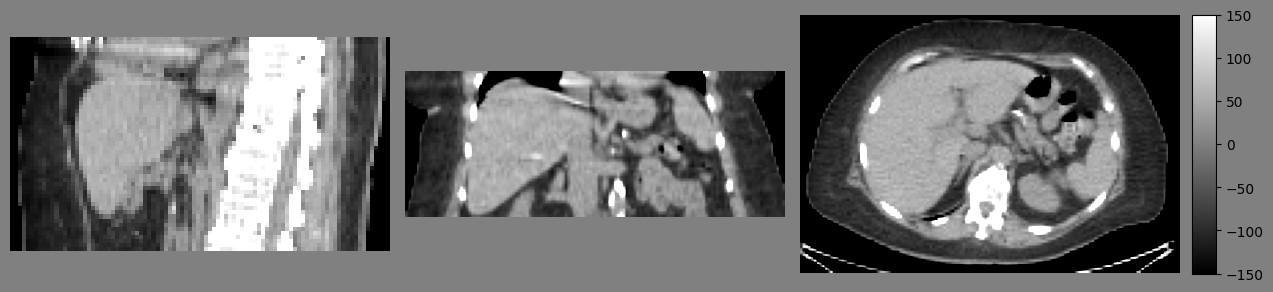

Deformed


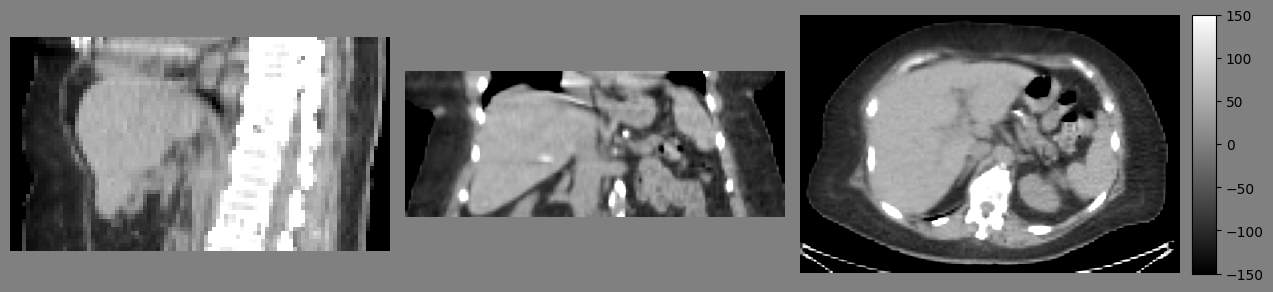

Difference:


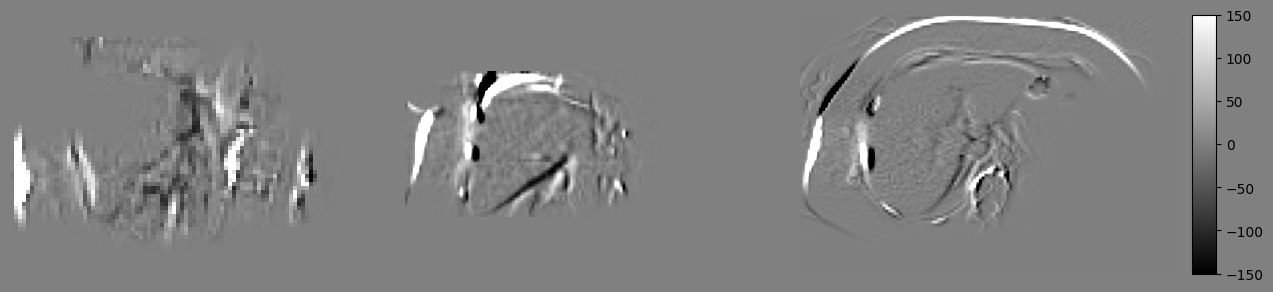

In [5]:
liver, *_ = imfusion.load('data/pet-ct-rtstruct/ct-liver.imf') 
liver_deformed, *_ = imfusion.load('data/pet-ct-rtstruct/ct-liver-deformed.imf')

print("Original:")
mpr_plot(liver[0], vmin=-150, vmax=150)
print("Deformed")
mpr_plot(liver_deformed[0], vmin=-150, vmax=150)
print("Difference:")
diff_image = imfusion.execute_algorithm("Base.ImageComparison", [liver, liver_deformed])[0]
mpr_plot(diff_image[0], vmin=-150, vmax=150)

In [6]:
def_algo = reg.ImageRegistrationAlgorithm(liver, liver_deformed, reg.ImageRegistrationAlgorithm.TransformationModel.DEMONS)

def_cfg = def_algo.configuration()
def_cfg_dict = def_cfg.asdict()
print(def_cfg_dict)
def_cfg_dict['Mode'] = 'Demons'
def_cfg_dict['Demons/0']['minLevel'] = 2
def_algo.configure(imfusion.Properties(def_cfg_dict))
def_algo.compute()

{'image2IsMoving': True, 'verbose': True, 'Mode': 'Demons', 'preprocessingOptions': 17, 'maxVRAM': 1024, 'targetRelSpacing': 0.5, 'Demons/0': {'minLevel': 1, 'maxLevel': 5, 'halfKernelSize': 2, 'alpha': 2.0, 'adjustment': 0, 'gradientType': 2, 'maxIterations': 100, 'restrictToInputs': True, 'damping': 1.0, 'tolAbs': 1e-06, 'verbose': True, 'noSmoothingFinalStep': False, 'affineSkip': 1, 'channelWeights': []}}


Original:


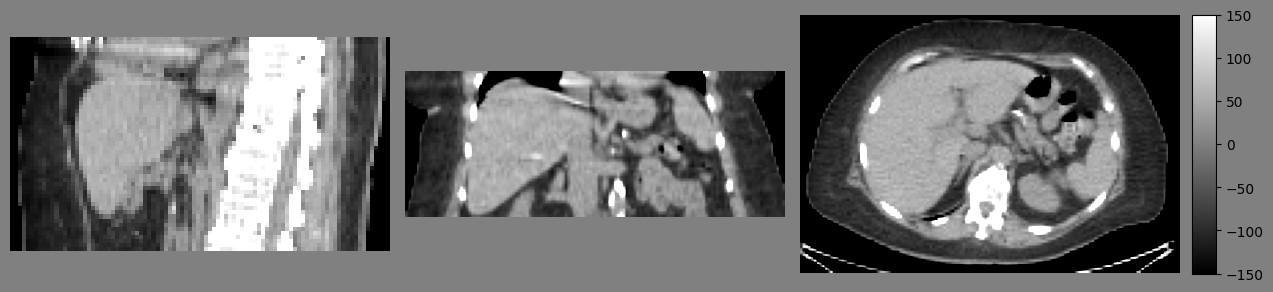

Deformed after Registration:


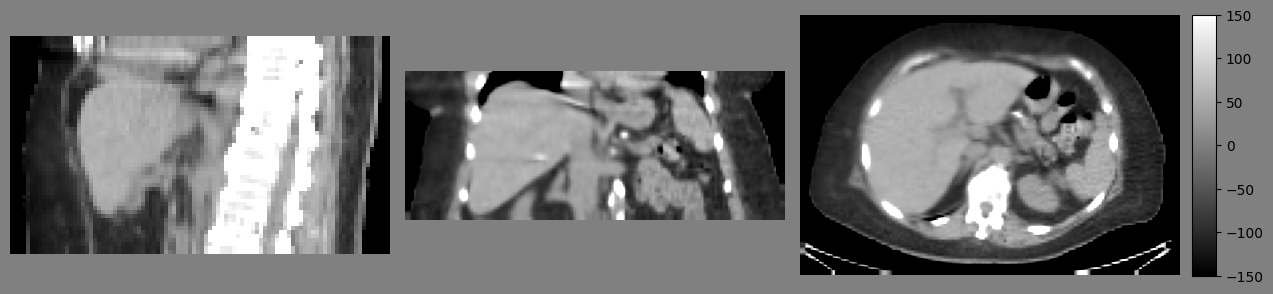

Difference:


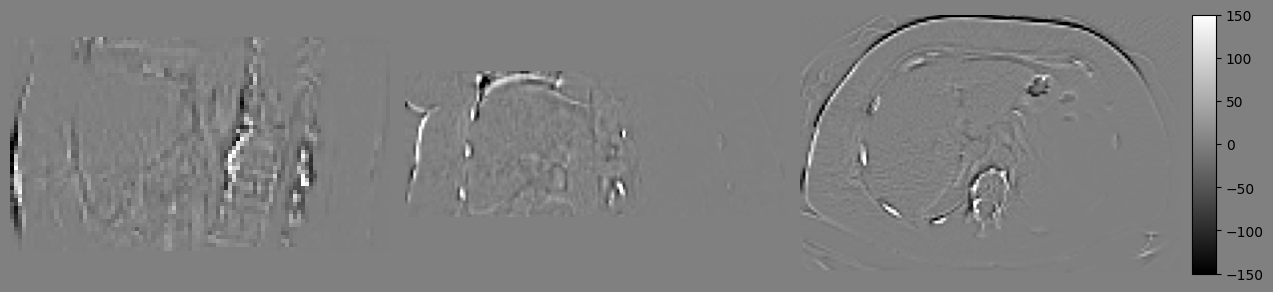

In [7]:
print("Original:")
mpr_plot(liver[0], vmin=-150, vmax=150)
print("Deformed after Registration:")
registered = imfusion.reg.apply_deformation(liver_deformed)
mpr_plot(registered[0], vmin=-150, vmax=150)
print("Difference:")
diff_image = imfusion.execute_algorithm("Base.ImageComparison", [liver, registered])[0]
mpr_plot(diff_image[0], vmin=-150, vmax=150)